In [249]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
# from dynamic_routing_analysis import decoding_utils
# from dynamic_routing_analysis import plot_utils
# import dynamic_routing_analysis as dra
# import pingouin as pg
import os
import random

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %matplotlib widget
# %matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
results_path="s3://aind-scratch-data/dynamic-routing/decoding/results/time_mod_keep_units_consistent_0/"

In [3]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.268.csv"
# session_table_path="/Users/ethan.mcbride/Data/DR/session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path)

dr_session_list=(
    session_table.filter(
    pl.col('project')=="DynamicRouting",
    pl.col('is_production'),
    pl.col('is_annotated'),
    pl.col('issues')=="",
    pl.col('is_good_behavior').eq(True),
    )['session_id'].to_list()
    )

In [4]:
#define grouping columns
grouping_cols = {
    'session_id',
    'structure',
    'electrode_group_names',
    'unit_subsample_size',
    'bin_center',
    'bin_size',
    'time_aligned_to',
    # 'unit_criteria',
}

#toggle combine_multi_probe_rec
combine_multi_probe_rec = True

if combine_multi_probe_rec:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().gt(1) | pl.col('is_sole_recording').eq(True)
else:
    combine_multi_probe_expr = pl.col('electrode_group_names').list.len().eq(1) | pl.col('is_sole_recording').eq(True)


In [5]:
#get predict proba from each structure-session

structure_grouping = {
    'SCop': 'SCs',
    'SCsg': 'SCs',
    'SCzo': 'SCs',
    'SCig': 'SCm',
    'SCiw': 'SCm',
    'SCdg': 'SCm',
    'SCdw': 'SCm',
    "ECT1": 'ECT',
    "ECT2/3": 'ECT',    
    "ECT6b": 'ECT',
    "ECT5": 'ECT',
    "ECT6a": 'ECT', 
    "ECT4": 'ECT',
}
keep_original_structure = False
if keep_original_structure:
    n_repeats = 2
else:
    n_repeats = 1

predict_proba_wo_repeats = (
    pl.scan_parquet(results_path)
    #make new column that indicates whether a row is the sole recording from a structure in a session
    .with_columns(
        pl.col('electrode_group_names').flatten().n_unique().eq(1).over(grouping_cols - {'electrode_group_names'}).alias('is_sole_recording'),     
    )
    #Grab only rows according to combine_multi_probe_rec toggle
    #Grab only rows that have is_all_trials == True, only these have predict_proba
    .filter(
        combine_multi_probe_expr,
        pl.col('is_all_trials'),
    )
    #join on the units table to get total number of units per structure
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/units.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
            )
            #make new rows according to structure_grouping
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()))
                .then(pl.col('structure').repeat_by(n_repeats))
                .otherwise(pl.col('structure').repeat_by(1))
            )
            .explode('structure')
            .with_columns(
                pl.when(pl.col('structure').is_in(structure_grouping.keys()).is_first_distinct().over('unit_id'))
                .then(pl.col('structure').replace(structure_grouping))
                .otherwise(pl.col('structure'))
            )
            .group_by('session_id','structure')
            .agg(
                pl.col('unit_id').len().alias('total_n_units')
            )
        ),
        on=['session_id','structure'],
        how='left',
    )
    .with_columns(
        pl.int_ranges(0, pl.col('predict_proba').list.len()).alias('trial_index')
    )
    .drop('shift_idx', 'is_all_trials', 'electrode_group_names', 'unit_criteria', 'is_sole_recording')
    .explode('predict_proba', 'trial_index')
    .group_by('session_id', 'structure', 'unit_subsample_size', 'trial_index', 'bin_center', 'bin_size', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').mean(),
        pl.col('predict_proba').mean(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
    )
    .join(
        other=(
            pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet')
            .with_columns(
                pl.col('session_id').str.split('_').list.slice(0, 2).list.join('_'),
                #iti column?
            )
            .select('session_id', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response')
        ),
        on=['session_id','trial_index'],
        how='inner',
    ) 
    .group_by('session_id', 'structure', 'unit_subsample_size', 'bin_center', 'time_aligned_to',)
    .agg(
        pl.col('balanced_accuracy_test').first(),
        pl.col('total_n_units').first(),
        # pl.col('unit_ids').first(),
        pl.col('predict_proba', 'trial_index', 'is_vis_rewarded', 'stim_name', 'is_response').sort_by('trial_index'),

    )
    .sort('session_id','structure', 'unit_subsample_size', 'bin_center')
    # .group_by('session_id','structure')
    .collect(engine='streaming')
)

In [6]:
predict_proba_pd=predict_proba_wo_repeats.to_pandas()

In [7]:
#choose one time bin to use
predict_proba_pd = predict_proba_pd.query('bin_center==-0.25')

In [8]:

def get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to):
    """
    Get the results for a specific session and structure.
    """
    
    if sel_time_aligned_to=='response_time':
        temp_trial_info=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                time_aligned_to=="stim_start_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                ).sort_values('bin_center').iloc[0]
        
        trial_index=temp_trial_info['trial_index'][temp_trial_info['is_response']]
        is_vis_rewarded=temp_trial_info['is_vis_rewarded'][temp_trial_info['is_response']]
        stim_name=temp_trial_info['stim_name'][temp_trial_info['is_response']]
        is_response=temp_trial_info['is_response'][temp_trial_info['is_response']]

        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="response_time" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
        trial_index_list=[]
        is_vis_rewarded_list=[]
        stim_name_list=[]
        is_response_list=[]
        for rr in range(len(example_area_results)):
            trial_index_list.append(trial_index)
            is_vis_rewarded_list.append(is_vis_rewarded)
            stim_name_list.append(stim_name)
            is_response_list.append(is_response)

        example_area_results['trial_index']=trial_index_list
        example_area_results['is_vis_rewarded']=is_vis_rewarded_list
        example_area_results['stim_name']=stim_name_list
        example_area_results['is_response']=is_response_list

    else:
        example_area_results=predict_proba_pd.query(f'session_id=="{sel_session}" and structure=="{sel_structure}" and \
                                                    time_aligned_to=="{sel_time_aligned_to}" and unit_subsample_size=={sel_unit_subsample_size}'
                                                    ).sort_values('bin_center').reset_index(drop=True)
        
    #get context switches
    is_context_switch=np.concatenate([[0],np.diff(example_area_results['is_vis_rewarded'].iloc[0])]).astype(bool)
    context_switch_list=[]
    for rr in range(len(example_area_results)):
        context_switch_list.append(is_context_switch)
    example_area_results['is_context_switch']=context_switch_list


    return example_area_results

In [427]:
sel_structure='MOs'
sel_session='742903_2024-10-22'
# predict_proba_pd.query('session_id=="742903_2024-10-22" and structure=="MOs"').to_csv(
#     rf"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\{sel_session}_{sel_structure}_predict_proba.csv"
# )
array=predict_proba_pd.query('session_id=="742903_2024-10-22" and structure=="MOs"')['predict_proba'].to_numpy()
np.save(
    rf"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\{sel_session}_{sel_structure}_predict_proba.npy",
    array[0]
)

In [429]:
np.load(
    rf"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\{sel_session}_{sel_structure}_predict_proba.npy",
)

array([0.6756125 , 0.29921171, 0.30403559, 0.26020126, 0.27173378,
       0.3077335 , 0.31598126, 0.25586604, 0.37419221, 0.27544507,
       0.2535671 , 0.26061502, 0.25074296, 0.29410396, 0.27470132,
       0.18820065, 0.27415426, 0.29611067, 0.32882782, 0.31415844,
       0.18175255, 0.26707981, 0.17576155, 0.24514334, 0.35552416,
       0.45916627, 0.25101457, 0.23440046, 0.20019154, 0.25195758,
       0.27882853, 0.21675521, 0.27988889, 0.31573717, 0.23796143,
       0.19107583, 0.30371239, 0.25744138, 0.21849745, 0.28409524,
       0.25188291, 0.23311385, 0.2657646 , 0.4142206 , 0.40955162,
       0.19101919, 0.28039191, 0.29129922, 0.43277496, 0.26414147,
       0.413341  , 0.30093855, 0.29066389, 0.26998916, 0.23898397,
       0.22000051, 0.28358536, 0.37912106, 0.32208492, 0.32212706,
       0.20059175, 0.31938543, 0.2906423 , 0.29690645, 0.29411476,
       0.21351206, 0.46460757, 0.27317957, 0.43202201, 0.43711397,
       0.54110326, 0.233348  , 0.44540727, 0.36300389, 0.38525

In [19]:
#get predict_proba relative to switches, make new table

### NOTE: designed for only 1 time_bin

sel_unit_subsample_size=20
sel_time_aligned_to='stim_start_time'

# get_trials_rel_to_switch=[-3,-2,-1,0,1,2,3,4]
get_trials_before_switch=-10
get_trials_after_switch=20

all_performance=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/performance.parquet').collect().to_pandas()
all_trials=pl.scan_parquet('s3://aind-scratch-data/dynamic-routing/cache/nwb_components/v0.0.268/consolidated/trials.parquet').collect().to_pandas()

context_switch_table={
    'session_id':[],
    'structure':[],
    'predict_proba':[],
    'bin_centers':[],
    'unit_subsample_size':[],
    'time_aligned_to':[],
    'trial_index':[],
    'trial_rel_to_switch':[],
    'switch_index_in_session':[],
    'is_response':[],
    'is_vis_rewarded':[],
    'is_contingent_switch':[],
    'stim_name':[],
    'dprime_before_switch':[],
    'dprime_after_switch':[],
}

for sel_session in predict_proba_pd['session_id'].unique():
    if sel_session not in dr_session_list:
        print(f"session {sel_session} not in dr_session_list; skipping")
        continue
    for sel_structure in predict_proba_pd.query('session_id==@sel_session')['structure'].unique():

        #get session-structure results
        example_area_results=get_session_structure_results(predict_proba_pd, sel_session, sel_structure, sel_unit_subsample_size, sel_time_aligned_to)

        predict_proba_stack=example_area_results['predict_proba'].values[0]

        session_performance=all_performance.query(f'session_id=="{sel_session}"')
        session_trials=all_trials.query(f'session_id=="{sel_session}"')

        #choose values based on their actual, not implied, trial index
        context_switch_trial_index=session_trials.query('is_block_switch')['trial_index'].values
        trial_index=example_area_results['trial_index'].iloc[0]

        #loop through context switches
        for ii,tt in enumerate(context_switch_trial_index):
            # print(f"Context switch {ii} of {len(context_switch_trial_index)}")
            # print(f"Trial {tt} of {len(example_area_results['is_context_switch'].iloc[0])}")
            dprime_before_switch=session_performance['cross_modality_dprime'].iloc[ii]
            dprime_after_switch=session_performance['cross_modality_dprime'].iloc[ii+1]

            is_contingent_switch=session_trials['is_response'].iloc[tt]

            #get the is_vis_context
            is_vis_rewarded=session_trials['is_vis_rewarded'].iloc[tt]

            t_diff = np.arange(get_trials_before_switch, get_trials_after_switch+1)
            adj_tt = tt + t_diff
            #make sure we don't go out of bounds
            adj_tt = np.clip(adj_tt, 0, len(example_area_results['is_context_switch'].iloc[0])-1)
                
            #get trial from predict_proba_stack
            predict_proba_values=predict_proba_stack[adj_tt]

            #get the bin center of the trial
            bin_centers=example_area_results['bin_center'].values

            #get the is_response
            is_response=example_area_results['is_response'].iloc[0][adj_tt]

            #get the stim_name
            stim_name=example_area_results['stim_name'].iloc[0][adj_tt]

            #append to the context switch table
            context_switch_table['session_id'].append(sel_session)
            context_switch_table['structure'].append(sel_structure)
            context_switch_table['predict_proba'].append(predict_proba_values)
            context_switch_table['bin_centers'].append(bin_centers)
            context_switch_table['unit_subsample_size'].append(sel_unit_subsample_size)
            context_switch_table['time_aligned_to'].append(sel_time_aligned_to)
            context_switch_table['trial_index'].append(trial_index[adj_tt])
            context_switch_table['trial_rel_to_switch'].append(t_diff)
            context_switch_table['switch_index_in_session'].append(ii)
            context_switch_table['is_response'].append(is_response)
            context_switch_table['is_vis_rewarded'].append(is_vis_rewarded)
            context_switch_table['is_contingent_switch'].append(is_contingent_switch)
            context_switch_table['stim_name'].append(stim_name)
            context_switch_table['dprime_before_switch'].append(dprime_before_switch)
            context_switch_table['dprime_after_switch'].append(dprime_after_switch)

context_switch_table_df=pd.DataFrame(context_switch_table)
# context_switch_table_df


session 620263_2022-07-26 not in dr_session_list; skipping
session 620263_2022-07-27 not in dr_session_list; skipping
session 620264_2022-08-02 not in dr_session_list; skipping
session 626791_2022-08-17 not in dr_session_list; skipping
session 628801_2022-09-19 not in dr_session_list; skipping
session 636397_2022-09-26 not in dr_session_list; skipping
session 636397_2022-09-27 not in dr_session_list; skipping
session 644547_2022-12-05 not in dr_session_list; skipping
session 644547_2022-12-06 not in dr_session_list; skipping
session 644866_2023-02-07 not in dr_session_list; skipping
session 646318_2023-01-17 not in dr_session_list; skipping
session 646318_2023-01-18 not in dr_session_list; skipping
session 649944_2023-02-27 not in dr_session_list; skipping
session 649944_2023-02-28 not in dr_session_list; skipping
session 662892_2023-08-21 not in dr_session_list; skipping
session 662983_2023-05-15 not in dr_session_list; skipping
session 662983_2023-05-16 not in dr_session_list; skippi

In [38]:
# predict_proba_stack
# example_area_results['predict_proba'].values[0]
# context_switch_table_df

(0.18, 0.82)

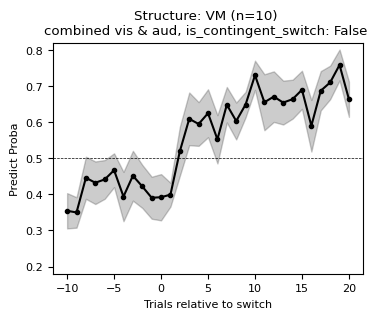

In [436]:
sel_structure='VM'
sel_is_vis_rewarded=True
sel_is_contingent_switch=False
combine_vis_aud=True

if combine_vis_aud:
    structure_predict_proba_vis=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==True and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
    structure_predict_proba_aud=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==False and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
    structure_predict_proba_aud=1-structure_predict_proba_aud
    structure_predict_proba=np.vstack((structure_predict_proba_vis, structure_predict_proba_aud))
else:
    structure_predict_proba=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)

trial_rel_to_switch=context_switch_table_df['trial_rel_to_switch'].values[0]

n_switches=len(structure_predict_proba)

fig,ax=plt.subplots(figsize=(4,3))
ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
ax.plot(trial_rel_to_switch,np.nanmean(structure_predict_proba,axis=0),'k.-')
ax.fill_between(trial_rel_to_switch, 
                np.nanmean(structure_predict_proba,axis=0) - stats.sem(structure_predict_proba,axis=0), 
                np.nanmean(structure_predict_proba,axis=0) + stats.sem(structure_predict_proba,axis=0), 
                alpha=0.2, color='k')
ax.set_xlabel('Trials relative to switch')
ax.set_ylabel('Predict Proba')
if combine_vis_aud:
    ax.set_title(f'Structure: {sel_structure} (n={n_switches}) \ncombined vis & aud, is_contingent_switch: {sel_is_contingent_switch} ')
else:
    ax.set_title(f'Structure: {sel_structure} (n={n_switches}) \nis_vis_rewarded: {sel_is_vis_rewarded}, is_contingent_switch: {sel_is_contingent_switch}')
ax.set_ylim(0.18,0.82)

In [376]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\SCm_combined_switches.pdf'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='pdf', pad_inches=0.1)

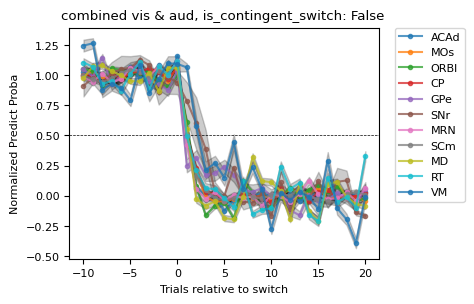

In [432]:
#plot multiple structures together
sel_structure_list=['ACAd','MOs','ORBl','CP','GPe','SNr','MRN','SCm','MD','RT','VM']
sel_is_vis_rewarded=False
sel_is_contingent_switch=False
combine_vis_aud=True
normalize=True

n_sessions={
    'structure':[],
    'n_sessions':[],
}

fig,ax=plt.subplots(figsize=(4,3))
ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)

for sel_structure in sel_structure_list:
    n_sessions['structure'].append(sel_structure)
    if combine_vis_aud:
        structure_predict_proba_vis=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==True and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
        structure_predict_proba_aud=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==False and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
        structure_predict_proba_aud=1-structure_predict_proba_aud
        structure_predict_proba=np.vstack((structure_predict_proba_vis, structure_predict_proba_aud))
        n_sessions['n_sessions'].append(context_switch_table_df.query('structure==@sel_structure and is_contingent_switch==@sel_is_contingent_switch')['session_id'].nunique())
    else:
        structure_predict_proba=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
        n_sessions['n_sessions'].append(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and is_contingent_switch==@sel_is_contingent_switch')['session_id'].nunique())

    trial_rel_to_switch=context_switch_table_df['trial_rel_to_switch'].values[0]

    n_switches=len(structure_predict_proba)
    if normalize:
        mean_pred_proba=np.nanmean(structure_predict_proba,axis=0)
        baseline_mean=np.nanmean(mean_pred_proba[trial_rel_to_switch<0])
        post_mean=np.nanmean(mean_pred_proba[trial_rel_to_switch>5])
        norm_predict_proba=(mean_pred_proba-baseline_mean)/(post_mean-baseline_mean)
        if sel_is_vis_rewarded==False:
            norm_predict_proba=1-norm_predict_proba
        ax.plot(trial_rel_to_switch,norm_predict_proba,label=sel_structure, marker='.',alpha=0.75)
        ax.fill_between(trial_rel_to_switch, 
                        norm_predict_proba - stats.sem(structure_predict_proba,axis=0), 
                        norm_predict_proba + stats.sem(structure_predict_proba,axis=0), 
                        alpha=0.2, color='k')
    else:
        ax.plot(trial_rel_to_switch,np.nanmean(structure_predict_proba,axis=0),label=sel_structure, marker='.',alpha=0.75)
        ax.fill_between(trial_rel_to_switch, 
                        np.nanmean(structure_predict_proba,axis=0) - stats.sem(structure_predict_proba,axis=0), 
                        np.nanmean(structure_predict_proba,axis=0) + stats.sem(structure_predict_proba,axis=0), 
                        alpha=0.2, color='k')
ax.set_xlabel('Trials relative to switch')
ax.set_ylabel('Normalized Predict Proba')
if combine_vis_aud:
    ax.set_title(f'combined vis & aud, is_contingent_switch: {sel_is_contingent_switch} ')
else:
    ax.set_title(f'is_vis_rewarded: {sel_is_vis_rewarded}, is_contingent_switch: {sel_is_contingent_switch}')
    # ax.set_ylim(0.18,0.82)

#plot legend outside axes
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


In [433]:
pd.DataFrame(n_sessions)

,structure,n_sessions
0,ACAd,25
1,MOs,57
2,ORBl,21
3,CP,52
4,GPe,6
5,SNr,1
6,MRN,18
7,SCm,28
8,MD,7
9,RT,9


In [420]:
#save as editable pdf
savepath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-08-01-predict_proba_corr_updates\multi_area_vis_to_aud_switches_more_areas.pdf'
fig.savefig(savepath, bbox_inches='tight', dpi=300,
            transparent=True, format='pdf', pad_inches=0.1)

In [385]:
np.nanmean(structure_predict_proba,axis=0).shape
trial_rel_to_switch.shape

(31,)

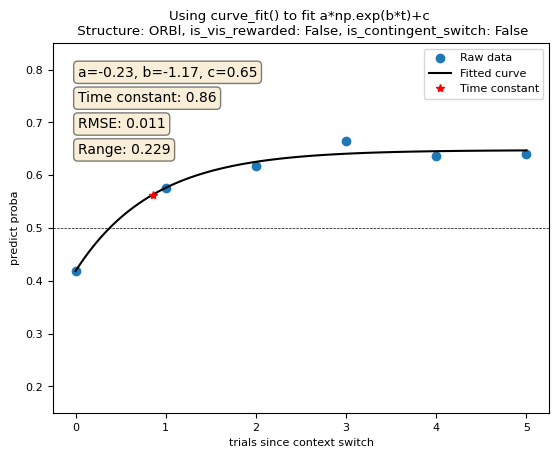

In [363]:
from scipy.optimize import curve_fit

fit_indices = np.where((trial_rel_to_switch>=0) & (trial_rel_to_switch<6))[0]

x= trial_rel_to_switch[fit_indices]
if sel_is_vis_rewarded==False:
        y=1-np.nanmean(structure_predict_proba[:,fit_indices], axis=0)
else:
        y= np.nanmean(structure_predict_proba[:,fit_indices], axis=0)   

a_guess = -0.5
b_guess = -0.5
c_guess = 0.7

# Fit the function a * np.exp(b * t) + c to x and y
popt, pcov = curve_fit(
    lambda t, a, b, c: a * np.exp(b * t) + c,
    x, y, p0=(a_guess, b_guess, c_guess)
)

# # Fit the function a * np.exp(b * t) + c to x and y
# popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y)

a = popt[0]
b = popt[1]
c = popt[2]

# Create the fitted curve
x_fitted = np.linspace(np.min(x), np.max(x), 100)
y_fitted = a * np.exp(b * x_fitted) + c

#find the time constant
ymin= np.min(y_fitted)
ymax= np.max(y_fitted)
ynorm= (y_fitted - ymin) / (ymax - ymin)

# time_constant_ind= np.where(ynorm >= (1-1/np.exp(1)))[0][0]  # Find the first index where the normalized y is greater than or equal to 0.632
# time_constant_x= x_fitted[time_constant_ind]
# time_constant_y= y_fitted[time_constant_ind]

time_constant_ind = np.where(x_fitted >= -1/b)[0][0]
time_constant_x = -1/b
time_constant_y = y_fitted[time_constant_ind]  # Adjusted to include y_min

y_predictions= a * np.exp(b * x) + c  # Calculate the predicted y values using the fitted parameters

#get root mean square error
rmse = np.sqrt(np.mean((y - y_predictions) ** 2))

#range of y_fitted
y_fitted_range = np.max(y_fitted) - np.min(y_fitted)

# Plot
ax = plt.axes()
ax.scatter(x, y, label='Raw data')
ax.axhline(0.5, color='k', linestyle='--', linewidth=0.5)
ax.plot(x_fitted, y_fitted, 'k', label='Fitted curve')
ax.plot(time_constant_x, time_constant_y, 'r*', label='Time constant')
if combine_vis_aud:
    ax.set_title(f'Using curve_fit() to fit a*np.exp(b*t)+c \n Structure: {sel_structure} (n={n_switches}), combined vis & aud, is_contingent_switch: {sel_is_contingent_switch}')
else:
       ax.set_title(f'Using curve_fit() to fit a*np.exp(b*t)+c \n Structure: {sel_structure}, is_vis_rewarded: {sel_is_vis_rewarded}, is_contingent_switch: {sel_is_contingent_switch}')
ax.set_ylabel('predict proba')
ax.text(0.05, 0.94, f'a={a:.2f}, b={b:.2f}, c={c:.2f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.05, 0.87, f'Time constant: {time_constant_x:.2f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.text(0.05, 0.8, f'RMSE: {rmse:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat',
        alpha=0.5))
ax.text(0.05, 0.73, f'Range: {y_fitted_range:.3f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat',
        alpha=0.5))
ax.set_ylim(0.15, 0.85)
ax.set_xlabel('trials since context switch')
ax.legend()

In [332]:
1/b

-1.3922315197340325

In [352]:
def fit_instruction_trials_to_exponential(structure_predict_proba, trial_rel_to_switch, sel_is_vis_rewarded):
    """
    Fit the instruction trials to an exponential function.
    """
    from scipy.optimize import curve_fit

    fit_indices = np.where((trial_rel_to_switch>=0) & (trial_rel_to_switch<6))[0]
    x= trial_rel_to_switch[fit_indices]
    if sel_is_vis_rewarded==False:
            y=1-np.nanmean(structure_predict_proba[:,fit_indices], axis=0)
    else:
            y= np.nanmean(structure_predict_proba[:,fit_indices], axis=0)
    
#     y_min= np.min(y)
#     y_max= np.max(y)
#     y= (y - y_min)  # Normalize y to start at 0
    
    a_guess = -0.5
    b_guess = -0.5
    c_guess = 0.7

    # Fit the function a * np.exp(b * t) + c to x and y
    popt, pcov = curve_fit(
        lambda t, a, b, c: a * np.exp(b * t) + c,
        x, y, p0=(a_guess, b_guess, c_guess)
    )

    a = popt[0]
    b = popt[1]
    c = popt[2]

    # Create the fitted curve
    x_fitted = np.linspace(np.min(x), np.max(x), 100)
    y_fitted = a * np.exp(b * x_fitted) + c

    #find the time constant
    ymin= np.min(y_fitted)
    ymax= np.max(y_fitted)
    ynorm= (y_fitted - ymin) / (ymax - ymin)

    time_constant_ind= np.where(ynorm >= (1-1/np.exp(1)))[0][0]  # Find the first index where the normalized y is greater than or equal to 0.632
    time_constant_x= x_fitted[time_constant_ind]
    time_constant_y= y_fitted[time_constant_ind]

    y_predictions= a * np.exp(b * x) + c  # Calculate the predicted y values using the fitted parameters

    #get root mean square error
    rmse = np.sqrt(np.mean((y - y_predictions) ** 2))

    #range of y_fitted
    y_fitted_range = np.max(y_fitted) - np.min(y_fitted)

    return popt, time_constant_x, time_constant_y, rmse, y_fitted_range

In [ ]:
# compute all these values for each structure

# TODO: compute for vis to aud, aud to vis, and combined -- add to table

sel_is_contingent_switch=False
combine_vis_aud=True
sel_is_vis_rewarded=True

exponential_fits_by_structure = {
    'structure': [],
    'a': [],
    'b': [],
    'c': [],
    '1/b': [],
    'time_constant_x': [],
    'time_constant_y': [],
    'rmse': [],
    'y_fitted_range': [],
    'n_switches': [],
    }

for sel_structure in context_switch_table_df['structure'].unique():

    if combine_vis_aud:
        if len(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and is_contingent_switch==@sel_is_contingent_switch')) == 0:
            print(f"No data for structure {sel_structure} with is_vis_rewarded={sel_is_vis_rewarded} and is_contingent_switch={sel_is_contingent_switch}. Skipping.")
            continue
        if len(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==False and is_contingent_switch==@sel_is_contingent_switch')) == 0:
            print(f"No data for structure {sel_structure} with is_vis_rewarded=False and is_contingent_switch={sel_is_contingent_switch}. Skipping.")
            continue
        structure_predict_proba_vis=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==True and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
        structure_predict_proba_aud=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==False and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)
        structure_predict_proba_aud=1-structure_predict_proba_aud
        structure_predict_proba=np.vstack((structure_predict_proba_vis, structure_predict_proba_aud))
    else:
        if len(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and is_contingent_switch==@sel_is_contingent_switch')) == 0:
            print(f"No data for structure {sel_structure} with is_vis_rewarded={sel_is_vis_rewarded} and is_contingent_switch={sel_is_contingent_switch}. Skipping.")
            continue
        structure_predict_proba=np.vstack(context_switch_table_df.query('structure==@sel_structure and is_vis_rewarded==@sel_is_vis_rewarded and is_contingent_switch==@sel_is_contingent_switch')['predict_proba'].values)

    trial_rel_to_switch=context_switch_table_df['trial_rel_to_switch'].values[0]

    n_switches=len(structure_predict_proba)

    # Fit the instruction trials to an exponential function
    try:
        popt, time_constant_x, time_constant_y, rmse, y_fitted_range = fit_instruction_trials_to_exponential(structure_predict_proba, trial_rel_to_switch, sel_is_vis_rewarded)
    except RuntimeError as e:
        print(f"Error fitting exponential for structure {sel_structure}: {e}")
        # If fitting fails, skip this structure
        print(f"Skipping structure {sel_structure} due to fitting error.")
        # You can choose to append NaN values or skip appending entirely
        exponential_fits_by_structure['structure'].append(sel_structure)
        exponential_fits_by_structure['a'].append(np.nan)
        exponential_fits_by_structure['b'].append(np.nan)
        exponential_fits_by_structure['c'].append(np.nan)
        exponential_fits_by_structure['1/b'].append(np.nan)
        exponential_fits_by_structure['time_constant_x'].append(np.nan)
        exponential_fits_by_structure['time_constant_y'].append(np.nan)
        exponential_fits_by_structure['rmse'].append(np.nan)
        exponential_fits_by_structure['y_fitted_range'].append(np.nan)
        exponential_fits_by_structure['n_switches'].append(n_switches)
        continue

    # Append the results to the dictionary
    exponential_fits_by_structure['structure'].append(sel_structure)
    exponential_fits_by_structure['a'].append(popt[0])
    exponential_fits_by_structure['b'].append(popt[1])
    exponential_fits_by_structure['c'].append(popt[2])
    exponential_fits_by_structure['1/b'].append(-1/popt[1])
    exponential_fits_by_structure['time_constant_x'].append(time_constant_x)
    exponential_fits_by_structure['time_constant_y'].append(time_constant_y)
    exponential_fits_by_structure['rmse'].append(rmse)
    exponential_fits_by_structure['y_fitted_range'].append(y_fitted_range)
    exponential_fits_by_structure['n_switches'].append(n_switches)

exponential_fits_by_structure_df = pd.DataFrame(exponential_fits_by_structure)



C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16816\1345075575.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16816\1345075575.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


Error fitting exponential for structure VISrl: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Skipping structure VISrl due to fitting error.
No data for structure VISa with is_vis_rewarded=True and is_contingent_switch=False. Skipping.
No data for structure SAG with is_vis_rewarded=True and is_contingent_switch=False. Skipping.


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_16816\1345075575.py:23: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(


No data for structure IG with is_vis_rewarded=False and is_contingent_switch=False. Skipping.
Error fitting exponential for structure CL: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Skipping structure CL due to fitting error.
Error fitting exponential for structure AON: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Skipping structure AON due to fitting error.
Error fitting exponential for structure LH: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Skipping structure LH due to fitting error.
No data for structure CLA with is_vis_rewarded=True and is_contingent_switch=False. Skipping.
No data for structure PP with is_vis_rewarded=True and is_contingent_switch=False. Skipping.
Error fitting exponential for structure SNr: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Skipping structure SNr due to fitting error.
Error fitting exponential f

In [354]:
exponential_fits_by_structure_df

,structure,a,b,c,1/b,time_constant_x,time_constant_y,rmse,y_fitted_range,n_switches
0,AUDp,-0.177529,-0.667976,0.599633,1.497060,1.414141,0.530604,0.007863,0.171237,13
1,AUDpo,-0.121768,-0.598437,0.576512,1.671019,1.565657,0.528800,0.022903,0.115658,20
2,CA1,-0.097893,-0.641631,0.538195,1.558529,1.464646,0.499946,0.006374,0.093935,119
3,CP,-0.355682,-0.682475,0.693046,1.465254,1.414141,0.557553,0.006445,0.343958,162
4,DG,-0.091383,-0.165951,0.571331,6.025872,2.676768,0.512725,0.004197,0.051526,83
...,...,...,...,...,...,...,...,...,...,...
118,VPMpc,-0.055584,-3.515194,0.568986,0.284479,0.303030,0.549829,0.041699,0.055584,6
119,LA,-0.092459,-1.128986,0.542153,0.885751,0.909091,0.509024,0.030098,0.092132,4
120,SEZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
121,VTA,-0.074376,-0.494486,0.471183,2.022303,1.767677,0.440151,0.127576,0.068100,3


<Axes: title={'center': 'Time constant of predict proba change after context switch (>=15 switches)'}, xlabel='structure', ylabel='Time constant (trials)'>

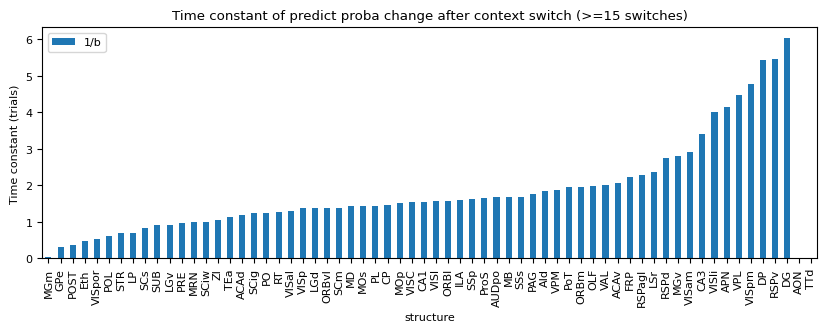

In [355]:
fig,ax=plt.subplots(figsize=(10,3))

exponential_fits_by_structure_df.query('n_switches>=15').sort_values('1/b').plot.bar(
    x='structure',y='1/b',ax=ax,
    title='Time constant of predict proba change after context switch (>=15 switches)',
    ylabel='Time constant (trials)',)



<Axes: title={'center': 'Magnitude of predict proba change after context switch (>=15 switches)'}, xlabel='structure', ylabel='change in predict proba'>

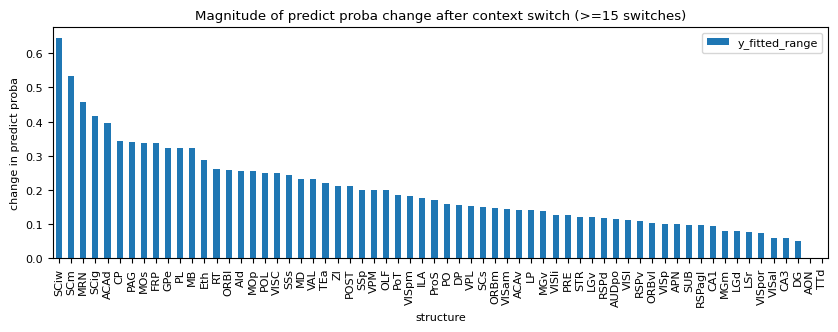

In [356]:
fig,ax=plt.subplots(figsize=(10,3))

exponential_fits_by_structure_df.query('n_switches>=15').sort_values('y_fitted_range', ascending=False).plot.bar(
    x='structure',y='y_fitted_range',ax=ax,
    title='Magnitude of predict proba change after context switch (>=15 switches)',
    ylabel='change in predict proba',)



Text(0.05, 0.95, 'Pearson r=-0.29')

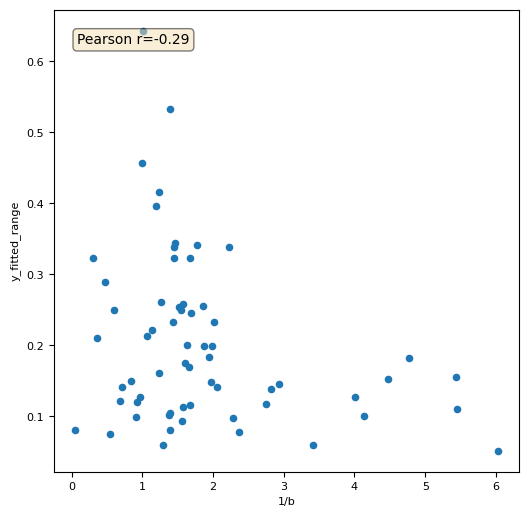

In [357]:
fig,ax=plt.subplots(figsize=(6,6))

#get pearson correlation between time_constant_x and y_fitted_range
correlation = exponential_fits_by_structure_df.query('n_switches>=15')['1/b'].corr(exponential_fits_by_structure_df.query('n_switches>=15')['y_fitted_range'])

exponential_fits_by_structure_df.query('n_switches>=15').plot.scatter(
    x='1/b', y='y_fitted_range', ax=ax,)
ax.text(0.05, 0.95, f'Pearson r={correlation:.2f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

<Axes: title={'center': 'fitting error (>=15 switches)'}, xlabel='structure', ylabel='RMSE'>

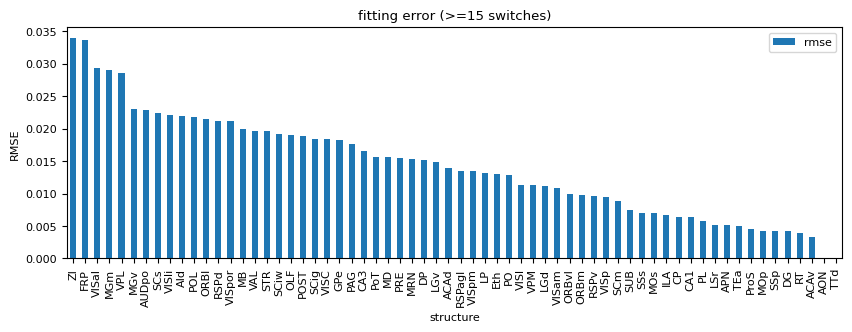

In [322]:
fig,ax=plt.subplots(figsize=(10,3))

exponential_fits_by_structure_df.query('n_switches>=15').sort_values('rmse', ascending=False).plot.bar(
    x='structure',y='rmse',ax=ax,
    title='fitting error (>=15 switches)',
    ylabel='RMSE',)



Text(0.65, 0.95, 'Pearson r=-0.47')

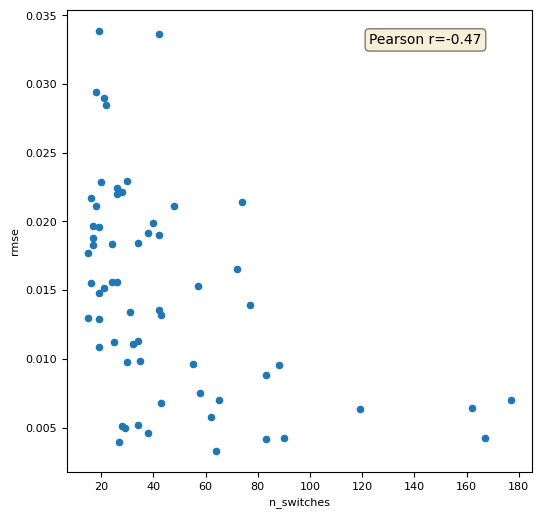

In [314]:
fig,ax=plt.subplots(figsize=(6,6))

#get pearson correlation between time_constant_x and y_fitted_range
correlation = exponential_fits_by_structure_df.query('n_switches>=15')['n_switches'].corr(exponential_fits_by_structure_df.query('n_switches>=15')['rmse'])

exponential_fits_by_structure_df.query('n_switches>=15').plot.scatter(
    x='n_switches', y='rmse', ax=ax,)
ax.text(0.65, 0.95, f'Pearson r={correlation:.2f}', transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))